Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/home/panas/Desktop/udacityData/' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified /home/panas/Desktop/udacityData/notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified /home/panas/Desktop/udacityData/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for /home/panas/Desktop/udacityData/notMNIST_large. This may take a while. Please wait.
['/home/panas/Desktop/udacityData/notMNIST_large/A', '/home/panas/Desktop/udacityData/notMNIST_large/B', '/home/panas/Desktop/udacityData/notMNIST_large/C', '/home/panas/Desktop/udacityData/notMNIST_large/D', '/home/panas/Desktop/udacityData/notMNIST_large/E', '/home/panas/Desktop/udacityData/notMNIST_large/F', '/home/panas/Desktop/udacityData/notMNIST_large/G', '/home/panas/Desktop/udacityData/notMNIST_large/H', '/home/panas/Desktop/udacityData/notMNIST_large/I', '/home/panas/Desktop/udacityData/notMNIST_large/J']
Extracting data for /home/panas/Desktop/udacityData/notMNIST_small. This may take a while. Please wait.
['/home/panas/Desktop/udacityData/notMNIST_small/A', '/home/panas/Desktop/udacityData/notMNIST_small/B', '/home/panas/Desktop/udacityData/notMNIST_small/C', '/home/panas/Desktop/udacityData/notMNIST_small/D', '/home/panas/Desktop/udacityData/notMNIST_small/E', '/home/pan

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [10]:
from IPython.display import Image
Image(filename=data_root+'/notMNIST_small/E/MDEtMDEtMDAudHRm.png') 

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, **normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. **

A few images might not be readable, we'll just skip them.

In [11]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling /home/panas/Desktop/udacityData/notMNIST_large/A.pickle.
/home/panas/Desktop/udacityData/notMNIST_large/A
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.f

 /home/panas/Desktop/udacityData/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.f

 /home/panas/Desktop/udacityData/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: /home/panas/Desktop/udacityData/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.128251
Standard deviation: 0.443121
Pickling /home/panas/Desktop/udacityData/notMNIST_large/B.pickle.

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.f


/home/panas/Desktop/udacityData/notMNIST_large/B
Could not read: /home/panas/Desktop/udacityData/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756306
Standard deviation: 0.454491
Pickling /home/panas/Desktop/udacityData/notMNIST_large/C.pickle.
/home/panas/Desktop/udacityData/notMNIST_large/C
Full dataset tensor: (52912, 28, 28)
Mean: -0.142258
Standard deviation: 0.439806
Pickling /home/panas/Desktop/udacityData/notMNIST_large/D.pickle.

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.f


/home/panas/Desktop/udacityData/notMNIST_large/D
Could not read: /home/panas/Desktop/udacityData/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0573677
Standard deviation: 0.455647
Pickling /home/panas/Desktop/udacityData/notMNIST_large/E.pickle.
/home/panas/Desktop/udacityData/notMNIST_large/E
Full dataset tensor: (52912, 28, 28)
Mean: -0.069899
Standard deviation: 0.452942
Pickling /home/panas/Desktop/udacityData/notMNIST_large/F.pickle.
/home/panas/Desktop/udacityData/notMNIST_large/F
Full dataset tensor: (52912, 28, 28)
Mean: -0.125583
Standard deviation: 0.44709
Pickling /home/panas/Desktop/udacityData/notMNIST_large/G.pickle.
/home/panas/Desktop/udacityData/notMNIST_large/G
Full dataset tensor: (52912, 28, 28)
Mean: -0.0945815
Standard deviation: 0.44624
Pickling /home/panas/Desktop/udacityData/notMNIST_lar

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.f


/home/panas/Desktop/udacityData/notMNIST_small/A
Could not read: /home/panas/Desktop/udacityData/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
Pickling /home/panas/Desktop/udacityData/notMNIST_small/B.pickle.
/home/panas/Desktop/udacityData/notMNIST_small/B
Full dataset tensor: (1873, 28, 28)
Mean: 0.00535608
Standard deviation: 0.457115
Pickling /home/panas/Desktop/udacityData/notMNIST_small/C.pickle.
/home/panas/Desktop/udacityData/notMNIST_small/C
Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
Pickling /home/panas/Desktop/udacityData/notMNIST_small/D.pickle.
/home/panas/Desktop/udacityData/notMNIST_small/D
Full dataset tensor: (1873, 28, 28)
Mean: -0.0492167
Standard deviation: 0.459759
Pickling /home/p

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/home/panas/anaconda2/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.f

 (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
Pickling /home/panas/Desktop/udacityData/notMNIST_small/F.pickle.
/home/panas/Desktop/udacityData/notMNIST_small/F
Could not read: /home/panas/Desktop/udacityData/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file '/home/panas/Desktop/udacityData/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.118185
Standard deviation: 0.452279
Pickling /home/panas/Desktop/udacityData/notMNIST_small/G.pickle.
/home/panas/Desktop/udacityData/notMNIST_small/G
Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
Pickling /home/panas/Desktop/udacityData/notMNIST_small/H.pickle.
/home/panas/Desktop/udacityData/notMNIST_small/H
Full dataset tensor: (1872, 28, 28)
Mean: -0.0586892
Standard deviation: 0.458759
Pickling /home/panas/Desktop/udacityData/notMNIST_small/I.pickle.
/home/panas/Desktop/udacityData/not

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [23]:
train = pickle.load(open(data_root+'/notMNIST_small/B.pickle'))
train.shape

(1873, 28, 28)

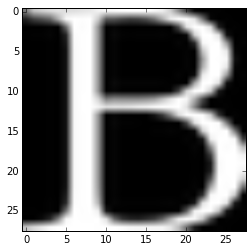

In [22]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt


plt.imshow(train[2].reshape((28, 28)), cmap=cm.Greys_r)
plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [25]:
numExamplesTest = []
numExamplesTrain = []
classes = ['A','B','C','D','E','F','G','H','I','J']

for i in classes:
    train = pickle.load(open(data_root+'/notMNIST_large/'+ i +'.pickle'))
    test = pickle.load(open(data_root+'/notMNIST_small/'+ i +'.pickle'))
    
    numExamplesTrain.append(train.shape[0])
    numExamplesTest.append(test.shape[0])
    

print('Test Data:' + str(numExamplesTest))
print('Train Data:' + str(numExamplesTrain))

Test Data:[1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]
Train Data:[52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [26]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [27]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [31]:
print('Train - unique labels: ' + str(np.unique(train_labels)))
print('Train - label counts: '+ str(np.bincount(train_labels)))
print('Valid - unique labels: ' + str(np.unique(valid_labels)))
print('Valid - label counts: '+ str(np.bincount(valid_labels)))
print('Test - unique labels: ' + str(np.unique(test_labels)))
print('Test - label counts: '+ str(np.bincount(test_labels)))

Train - unique labels: [0 1 2 3 4 5 6 7 8 9]
Train - label counts: [20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]
Valid - unique labels: [0 1 2 3 4 5 6 7 8 9]
Valid - label counts: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
Test - unique labels: [0 1 2 3 4 5 6 7 8 9]
Test - label counts: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Finally, let's save the data for later reuse:

In [32]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [33]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### Notes 



- Training and cross validation overlap: model has seen data during training that is used in CV, so CV results will be overly optimistic. Hence a wrong model could be chosen form CV and its estimated model performance might be estimated too high.

- Cross validation and test overlap: the test results will be overly optimistic as the model best performing on CV was selected to be used on test data. Hence the final (e.g. reported) model performance might be too high.

- Training and test overlap: the test results will be overly optimistic, as the model was using the same data during training already - again, the final (e.g. reported) model performance might be too high.


In [92]:
def overlapCount(train,test):
    import hashlib
    from functools import reduce
    
    #convert images to hexadecimal
    train_hex = [hashlib.md5(np.ravel(image)).hexdigest() for image in train]
    test_hex = [hashlib.md5(np.ravel(image)).hexdigest() for image in test]
    
    # Individual datasets
    trainOverlap = len(train_hex) - np.unique(train_hex).shape[0]
    trainOverlapPortion = np.double(trainOverlap / float(len(train_hex)))
    
    testOverlap = len(test_hex) - np.unique(test_hex).shape[0]
    testOverlapPortion = np.double(testOverlap / float(len(test_hex)))
    
    # Inter-dataset Overlap
    trainTestOverlap = len(reduce(np.intersect1d, (train_hex,test_hex)))
    trainTestOverlapPortion = np.double(trainTestOverlap / float(len(test_hex)))
    
    print("Train set number of examples overlap: " + str(trainOverlap) + 
          ' Portion of examples: ' + str(trainOverlapPortion))
    
    print("Test set number of examples overlap: " + str(testOverlap) + 
          ' Portion of examples: ' + str(testOverlapPortion))
    
    print("Test set number of images overlap with Train set: " + str(trainTestOverlap) + 
          ' Portion of examples: ' + str(trainTestOverlapPortion))

In [93]:
overlapCount(train_dataset,valid_dataset)

Train set number of examples overlap: 12643 Portion of examples: 0.063215
Test set number of examples overlap: 129 Portion of examples: 0.0129
Test set number of images overlap with Train set: 954 Portion of examples: 0.0954


In [94]:
overlapCount(train_dataset,test_dataset)

Train set number of examples overlap: 12643 Portion of examples: 0.063215
Test set number of examples overlap: 191 Portion of examples: 0.0191
Test set number of images overlap with Train set: 1114 Portion of examples: 0.1114


In [95]:
overlapCount(valid_dataset,test_dataset)

Train set number of examples overlap: 129 Portion of examples: 0.0129
Test set number of examples overlap: 191 Portion of examples: 0.0191
Test set number of images overlap with Train set: 60 Portion of examples: 0.006


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [109]:
# preparing the datasets changing the shape
train = np.array([np.ravel(image) for image in train_dataset])
valid = np.array([np.ravel(image) for image in valid_dataset])
test = np.array([np.ravel(image) for image in test_dataset])

# import the classifer
# did not use the validation set for parameter optimization however we know how to use it

from sklearn import linear_model
from sklearn.grid_search import GridSearchCV

LR = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1)
parameters = {'C':np.logspace(-4,2,2)}

clf = GridSearchCV(LR, parameters,n_jobs=-1,cv=2,verbose=1)
clf.fit(train, train_labels)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done   3 out of   4 | elapsed:  1.1min remaining:   21.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          penalty='l2', random_state=1, solver='lbfgs', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'C': array([  1.00000e-04,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [111]:
# prediction
y_pred = clf.predict(test)

# classification report
from sklearn.metrics import classification_report
target_names = classes#np.unique(train_labels)

print(classification_report(test_labels, y_pred, target_names=target_names))

             precision    recall  f1-score   support

          A       0.92      0.91      0.91      1000
          B       0.92      0.90      0.91      1000
          C       0.90      0.94      0.92      1000
          D       0.93      0.91      0.92      1000
          E       0.91      0.87      0.89      1000
          F       0.88      0.93      0.91      1000
          G       0.91      0.90      0.90      1000
          H       0.92      0.89      0.91      1000
          I       0.86      0.85      0.86      1000
          J       0.87      0.93      0.90      1000

avg / total       0.90      0.90      0.90     10000



In [ ]:
# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)